In [1]:
#move data to different fileder
import csv
import shutil
import os

file_path=('./')
change_train_path=(file_path+'dataset/tra/')
change_validation_path=(file_path+'dataset/val/')
change_test_path=(file_path+'dataset/tes/')
original_train_path=(file_path+'data/training/')
original_validation_path=(file_path+'data/validation/')
original_test_path=(file_path+'data/test/')

with open('gt_training.csv',"rt", encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    rows= [row for row in reader]
    for row in rows:
        if os.path.exists(original_train_path+row[0]+'.png'):
            full_path = original_train_path+row[0]+'.png'
            shutil.move(full_path, change_train_path + row[1] +'/')
        elif os.path.exists(original_validation_path+row[0]+'.png'):
            full_path = original_validation_path+row[0]+'.png'
            shutil.move(full_path, change_validation_path + row[1] +'/')
        elif os.path.exists(original_test_path+row[0]+'.png'):
            full_path = original_test_path+row[0]+'.png'
            shutil.move(full_path, change_test_path + row[1] +'/')
print('finish trans')

finish trans


In [2]:
import torch.nn as nn
from torch import nn
import torch
import torchvision
from torchvision import transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision import transforms
import random
import os
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

In [7]:
#change FC layer
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

for parma in model.parameters():
    parma.requires_grad = False
          
model.classifier = torch.nn.Sequential(nn.Dropout(),
                                       nn.Linear(256 * 6 * 6, 4096),
                                       nn.ReLU(inplace=True),
                                       nn.Dropout(),
                                       nn.Linear(4096, 4096),
                                       nn.ReLU(inplace=True),
                                       nn.Dropout(0.5),
                                       nn.Linear(4096, 1000),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(1000,6))
#model.eval()
#print(model.state_dict().keys())
model

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#evaluation

def eval_model_train(model, trainLoader, tra_acc_list):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainLoader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of trainloader: %d %%' % (100 * correct / total))
    tra_acc_list.append(100 * correct / total) 
    
def eval_model_validation(model, validationLoader, val_acc_list):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationLoader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of validationloader: %d %%' % (100 * correct / total))
    val_acc_list.append(100 * correct / total)

cuda:0


In [5]:
#dataset
transform = transforms.Compose([
    transforms.Resize(300),
    transforms.CenterCrop(300),
    transforms.RandomAffine(5),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = ImageFolder(file_path+'dataset/tra',  transform=transform)
validationset = ImageFolder(file_path+'dataset/val', transform=transform)
testset = ImageFolder(file_path+'dataset/tes',  transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

classes = ('Centromere','Golgi','Homogeneous','Nucleolar','NuMem','Speckled')

tra_acc_list, val_acc_list, loss_list = [], [], []

#optimizer and loss
import torch.optim as optim
lr=0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=5, verbose=True,
        threshold=lr, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

#gpu
torch.cuda.empty_cache()
model=model.cuda()
criterion = criterion.cuda()
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

In [1]:

epoch_num=40
iteration=10
#train process
for epoch in range(epoch_num):  # loop over the dataset multiple times

    epoch_str = f' Epoch {epoch + 1}/{epoch_num} '
    print(f'{epoch_str:-^40s}')
    print(f'Learning rate: {optimizer.param_groups[0]["lr"]}')
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].cuda(),data[1].cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % iteration == iteration - 1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / iteration))
            loss_list.append(running_loss / iteration)
        running_loss = 0.0
    eval_model_train(model, trainloader, tra_acc_list)            
    eval_model_validation(model, validationloader, val_acc_list)
    scheduler.step(loss.item())

print('Finished Training')
# print(tra_acc_list)
# print(val_acc_list)
# print(loss_list)

In [17]:
def eval_model_test(model, testLoader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testLoader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of test: %d %%' % (100 * correct / total))

eval_model_test(model, testloader)

Accuracy of test: 92 %


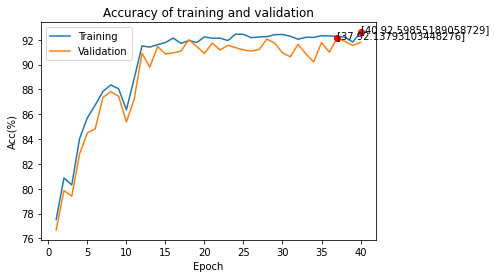

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def show_point(max_id, list):
    show_max='['+str(max_id+1)+' '+str(list[max_id])+']'
    plt.annotate(show_max, xytext=(max_id+1, list[max_id]), xy=(max_id+1, list[max_id]))
    
x_acc=[]
for i in range(len(tra_acc_list)):
    x_acc.append(i+1)

x=np.array(x_acc)
y1=np.array(tra_acc_list)
y2=np.array(val_acc_list)
max1=np.argmax(y1)
max2=np.argmax(y2)
plt.title('Accuracy of training and validation')
plt.xlabel('Epoch')
plt.ylabel('Acc(%)')
plt.plot(x, y1, label="Training")
plt.plot(x, y2, label="Validation")
plt.plot(1+max1, y1[max1], 'r-o')
plt.plot(1+max2, y2[max2], 'r-o')
show_point(max1, y1)
show_point(max2, y2)
plt.legend()
plt.show()

No handles with labels found to put in legend.


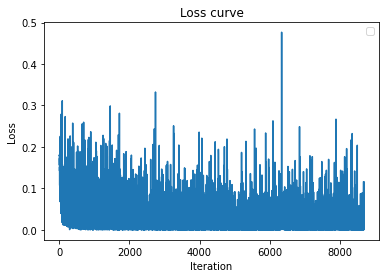

In [15]:
x_loss=[]
for i in range(len(loss_list)):
    x_loss.append(i+1)
    
plt.title('Loss curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(x_loss, loss_list)
plt.legend()
plt.show()